# Physical Characteristics

The notebook is used to calculate the percentage changes between physcial characteristics which may affect the number of calories burned. These outputs will then be used as a weighting to scale the calorie prediction from the model. The characteristics explored here are age, sex and BMI.

In [7]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Import the data
cal_df = pd.read_csv('calories.csv')
ex_df = pd.read_csv('exercise.csv')

In [9]:
# Create a combined BMI column
# Drop uncessecary rows (height and weight have been combined into BMI, and body temp won't be used as a factor) 
# Merge the calories data with the exercise data

ex_df['BMI'] = ex_df.apply(lambda row: row['Weight'] / ((row['Height']/100)**2), axis = 1)
df = pd.merge(ex_df, cal_df, on='User_ID', how='inner')
df.drop(columns = ['User_ID', 'Height', 'Weight', 'Body_Temp'], inplace = True)
df.head()

,Gender,Age,Duration,Heart_Rate,BMI,Calories
0,male,68,29.0,105.0,26.038781,231.0
1,female,20,14.0,94.0,21.773842,66.0
2,male,69,5.0,88.0,24.655910,26.0
3,female,34,13.0,100.0,22.159109,71.0
4,female,27,10.0,81.0,24.456063,35.0


<Axes: >

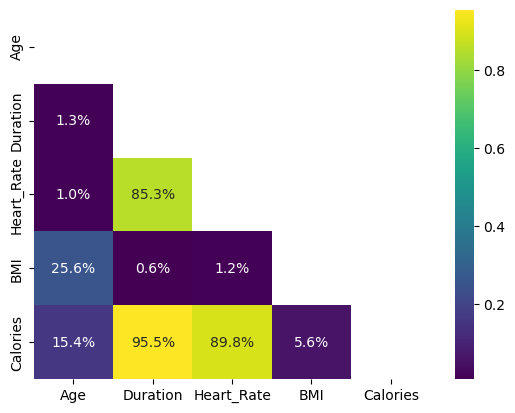

In [10]:
# Visualise the correlations between variables
sns.heatmap(df.corr(numeric_only = True),
           cmap = 'viridis',
           annot = True,
           fmt = '0.1%',
           mask = np.triu(df.corr(numeric_only = True)))

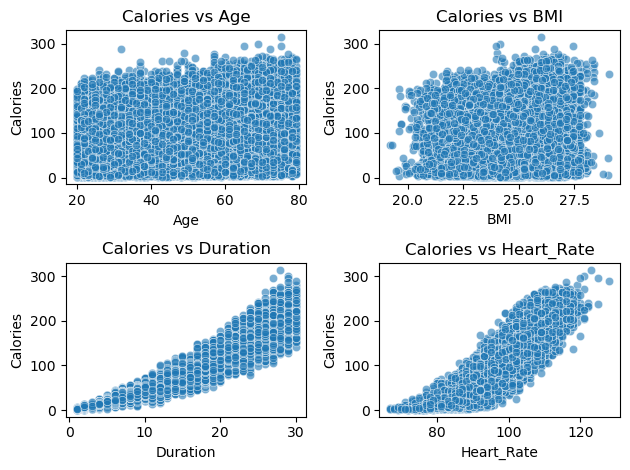

In [11]:
# Explore these relationships further
continuous_vars = ['Age', 'BMI', 'Duration', 'Heart_Rate']
for i, cont in enumerate(continuous_vars, 1):
    plt.subplot(2, 2, i)  # Arranging in a 2-row, 3-column grid
    sns.scatterplot(x=df[cont], y=df['Calories'], alpha=0.6)
    plt.title(f'Calories vs {cont}')
plt.tight_layout()
plt.show()

In [12]:
# Create an 'Age Category' column
bins = list(range(20, 90, 10))  # [20, 30, 40, ..., 80]
labels = [f"{i}-{i+9}" for i in range(20, 80, 10)]  # ["20-29", "30-39", ..., "70-79"]

df['Age Category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


# Create a 'BMI Category' column
bmi_bins = list(range(19, 33, 3))  # [19, 22, 25, 28, 31]
bmi_labels = [f"{i}-{i+2}" for i in range(19, 31, 3)]  # ["19-21", "22-24", ..., "28-30"]

df['BMI Category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

In [13]:
# Scale all the calories to be for 30mins of exercise - the relationship between calories and duration is linear so this shouldn't skew the data too much
# Beginner: <60% MHR, Intermediate: 70% MHR, Advanced: Anything above

df['Calories 30'] = df.apply(lambda row: row['Calories'] * (30/row['Duration']), axis = 1)
df['Max HR'] = df['Age'].apply(lambda x: 220 - x)
df['Difficulty'] = df.apply(lambda row: 'Beginner' if row['Heart_Rate'] < row['Max HR']*0.6 else ('Intermediate' if row['Heart_Rate'] < row['Max HR']*0.7 else 'Advanced'), axis=1)

In [14]:
# This row skews the BMI % change a lot so it will be dropped
df = df.drop(583)

In [30]:
# Calculate the average percentage increase in calories burned between men and women, keeping confounders constant (difficulty, age and BMI)
# Use female as the baseline
grouped = df.groupby(['Difficulty', 'Age Category', 'BMI Category', 'Gender'], observed = False)['Calories 30'].mean().unstack()
grouped = grouped.dropna()
grouped['Percentage Difference'] = ((grouped['male'] - grouped['female']) / grouped['female']) * 100
grouped['Percentage Difference'].mean()

7.3975454163254275

In [32]:
# Calculate the average percentage increase in calories burned between BMI categories, keeping confounders constant (difficulty, age and sex)
# Use '25-27' as the baseline to calculate % differences from
grouped = df.groupby(['Difficulty', 'Age Category', 'Gender', 'BMI Category'], observed = False)['Calories 30'].mean().unstack()
grouped = grouped.dropna(how='all')

# Calculate percentage difference between each BMI category and the next
bmi_categories = ['19-21', '22-24', '25-27', '28-30']
reference_category = '25-27'
percentage_diffs = {}

for cat in bmi_categories:
    if cat != reference_category:  # Compare only with '25-27'
        # Ensure we don't compute percentage difference where either value is NaN
        valid_rows = grouped[[reference_category, cat]].dropna()
        
        if not valid_rows.empty:  # Proceed only if there are valid values
            pct_diff = ((valid_rows[cat] - valid_rows[reference_category]) / valid_rows[reference_category]) * 100
            percentage_diffs[cat] = pct_diff.mean()

percentage_diffs

{'19-21': 2.573484064793065,
 '22-24': -0.6166655963535064,
 '28-30': 0.8523596527700462}

In [34]:
# Calculate the average percentage increase in calories burned between age categories, keeping confounders constant (difficulty, sex and BMI)
# Use '30-39' as the baseline to calculate % differences from
grouped = df.groupby(['Difficulty', 'Gender', 'BMI Category', 'Age Category'], observed = False)['Calories 30'].mean().unstack()
grouped = grouped.dropna(how='all')

# Calculate percentage difference between each age category and the next
age_categories = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
reference_category = '30-39'
percentage_diffs = {}

for cat in age_categories:
    if cat != reference_category:  # Compare only with '30-39'
        # Ensure we don't compute percentage difference where either value is NaN
        valid_rows = grouped[[reference_category, cat]].dropna()
        
        if not valid_rows.empty:  # Proceed only if there are valid values
            pct_diff = ((valid_rows[cat] - valid_rows[reference_category]) / valid_rows[reference_category]) * 100
            percentage_diffs[cat] = pct_diff.mean()

percentage_diffs

{'20-29': -1.3431775189158592,
 '40-49': 0.16434036161519347,
 '50-59': -2.119927642165567,
 '60-69': -5.845602151778729,
 '70-79': -8.820958217460053}